## Import lib

In [3]:
import json
from openai import OpenAI
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pirayan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Transcribe

In [41]:
client = OpenAI()

audio_file= open("../audio/elonmusk.mp3", "rb")
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=audio_file,
    response_format="verbose_json",
    timestamp_granularities=["word"],
)

print(transcription.words[:5])

[TranscriptionWord(end=0.4000000059604645, start=0.0, word='Are'), TranscriptionWord(end=0.800000011920929, start=0.4000000059604645, word='you'), TranscriptionWord(end=1.159999966621399, start=0.800000011920929, word='shocked'), TranscriptionWord(end=1.6799999475479126, start=1.159999966621399, word='at'), TranscriptionWord(end=1.899999976158142, start=1.6799999475479126, word='the')]


## Some EDA On the data

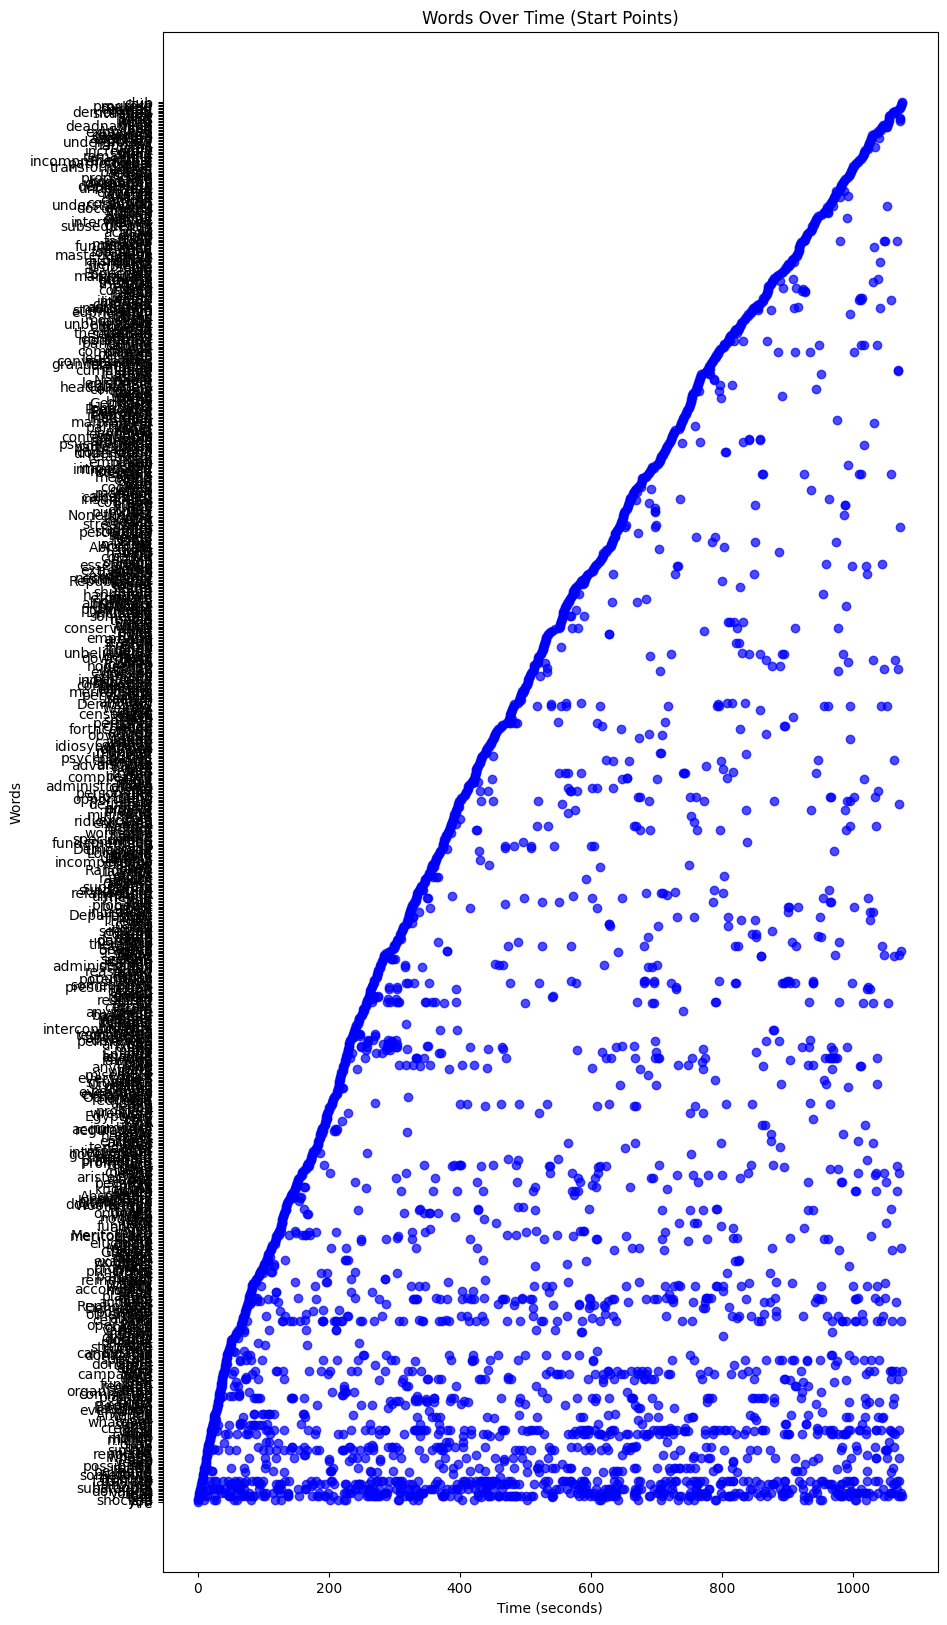

In [44]:
import matplotlib.pyplot as plt

words = [w.word for w in transcription.words]
start_times = [w.start for w in transcription.words]
end_times = [w.end for w in transcription.words]

fig, ax = plt.subplots(figsize=(10,20))
ax.scatter(start_times, words, color="blue", alpha=0.7)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Words")
ax.set_title("Words Over Time (Start Points)")
plt.show()

## Segmenting The words

In [48]:
def collect_uppercase_sentences(transcription):
    uppercase_sentences = []
    current_sentence = []
    sentence_start_time = None
    last_end_time = None

    for idx, word_data in enumerate(transcription.words):
        word = word_data.word.strip()  # Remove surrounding spaces
        start_time = word_data.start
        end_time = word_data.end

        # If word is empty, skip it
        if not word:
            continue

        # If a valid end_time exists, update last_end_time
        if end_time is not None:
            last_end_time = end_time

        # Starts with Upper (ignore "I")
        if word[0].isupper() and word != "I":
            # If there's an existing sentence, save it first
            if current_sentence and sentence_start_time is not None:
                full_sentence = " ".join(current_sentence)
                uppercase_sentences.append((sentence_start_time, last_end_time, full_sentence))

            # New sentence
            current_sentence = [word]
            sentence_start_time = start_time
        else:
            current_sentence.append(word)

    if current_sentence and sentence_start_time is not None:
        full_sentence = " ".join(current_sentence)
        uppercase_sentences.append((sentence_start_time, last_end_time, full_sentence))

    return uppercase_sentences

# Example usage:
uppercase_sentences_list = collect_uppercase_sentences(transcription)


In [49]:
for start_time, end_time, sentence in uppercase_sentences_list:
    start_display = f"{start_time:.2f}s" if start_time is not None else "Unknown"
    end_display = f"{end_time:.2f}s" if end_time is not None else "Unknown"
    print(f"[{start_display} - {end_display}] {sentence}")

[0.00s - 7.70s] Are you shocked at the fact that you're donating a substantial amount of money to facilitate
[7.20s - 8.20s] Trump's election
[8.08s - 13.22s] Is that something you would have believed in the realm of possibility say five years ago
[13.04s - 16.28s] So what's been reported in the media is simply not true
[16.08s - 16.82s] Oh okay
[16.62s - 19.62s] I'm not donating 45 million a month to
[19.62s - 20.00s] Trump
[19.76s - 23.36s] And now what I have done is I have created a
[23.36s - 23.82s] PAC or super
[23.78s - 26.36s] PAC whatever you want to call it which I simply call it the
[26.00s - 26.72s] America
[26.36s - 27.96s] PAC
[27.40s - 30.08s] Do you want to tell everybody who's listening what a
[30.08s - 30.76s] PAC is
[30.76s - 31.96s] Because people just don't know
[31.96s - 33.46s] It's a political action committee
[33.22s - 34.48s] It's an organization
[34.36s - 36.86s] It's a legal entity that can receive funding
[36.60s - 40.12s] That funding can then be used to h

## Get the sentiment score from NLTK(VADER)

In [50]:
sia = SentimentIntensityAnalyzer()

timestamps = []
sentiments = []

for sentence_start, sentence_end, sentence in uppercase_sentences_list:
    sentiment_score = sia.polarity_scores(sentence)['compound']

    timestamps.append(sentence_start)
    sentiments.append(sentiment_score)


In [51]:
average_sentiment = sum(sentiments) / len(sentiments)

In [52]:
section_changes = [word_data.start for word_data in transcription.words if word_data.word == "🎵"]

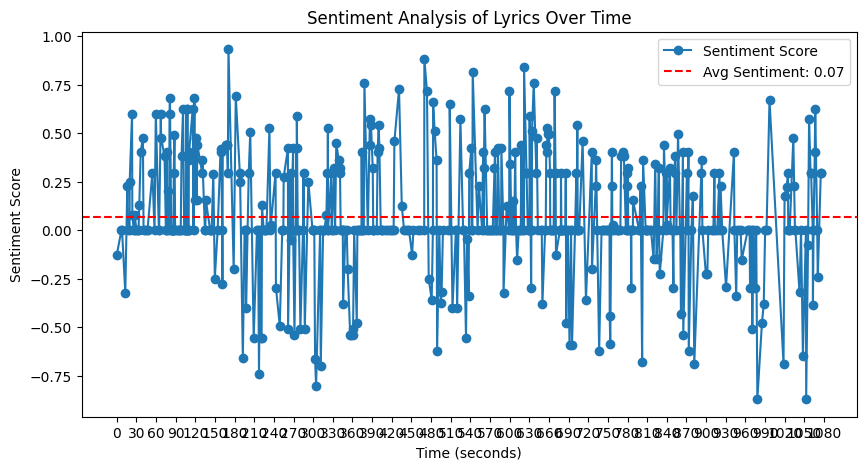

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(timestamps, sentiments, marker='o', linestyle='-', label="Sentiment Score")

for transition_time in section_changes:
    plt.axvline(transition_time, color='blue', linestyle='--', alpha=0.6, label="Instruments Break" if transition_time == section_changes[0] else "")

plt.xlabel("Time (seconds)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of Lyrics Over Time")
plt.axhline(average_sentiment, color='red', linestyle='--', label=f"Avg Sentiment: {average_sentiment:.2f}")
plt.xticks(np.arange(0, max(timestamps) + 30, 30))
plt.legend()
plt.show()